In [30]:
install.packages("e1071")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


<div><img src="http://www.stevinsonauto.net/assets/Icon_Brake.png", width=270, height=270, align = 'right'> 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/IBM_logo.svg/640px-IBM_logo.svg.png", width = 90, height = 90, align = 'right', style="margin:0px 25px"></div>

# Classifying Driver Type with Brake Events
##### By Rafi Kurlansik and Ross Lewis

________________________________

**Table of contents**
    
* [Problem Statement](#problemStatement)
    
* [Exploratory Data Analysis](#eda)

* [Modeling](#ml)
    
* [Data and Model Export](#export)

* [Conclusion](#conclusion)

______________________

<a id='problemStatement'></a>

### Problem Statement

The service bays at dealerships have seen an increase in warranty claims related to brakes.  Using historical telematics data of known driver types, can we classify the driving style of customers making warranty claims?

________
<a id='eda'></a>

### Exploratory Data Analysis

In [31]:

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_1 <- list(
    endpoint = "https://s3-api.us-geo.objectstorage.service.networklayer.com",
    api_key = "swN0j8PkWQUmmMAV_mXHCnWCoDYLokOPOBPEuOrPycUT",
    secret_key = "d11ef63bf5a732829ea5e37201dbb25f1d0550cce6e4ba45",
    iam_service_id = "iam-ServiceId-f82555c9-a3a8-4c9d-a891-09e523ae87e6",
    access_key = "2f5f7f07a5be45fa916904fa8a52162b",
    bucket_name = "rexamples-donotdelete-pr-v0lkm71mfndwel",
    file_name = "historical_brake_events.csv",
    iam_service_endpoint = "https://iam.bluemix.net/oidc/token")


In [32]:

library("aws.s3")

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
Sys.setenv("AWS_ACCESS_KEY_ID" = "2f5f7f07a5be45fa916904fa8a52162b", "AWS_SECRET_ACCESS_KEY" = "d11ef63bf5a732829ea5e37201dbb25f1d0550cce6e4ba45")
url <- "s3-api.us-geo.objectstorage.service.networklayer.com"
bucket <- "rexamples-donotdelete-pr-v0lkm71mfndwel"
headers <- list(`x-amz-content-sha256`="e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855")

obj <- s3HTTP(
    verb = "GET",
    bucket = bucket,
    headers = headers,
    path = "historical_brake_events.csv",
    key = Sys.getenv("AWS_ACCESS_KEY_ID"),
    secret = Sys.getenv("AWS_SECRET_ACCESS_KEY"),
    check_region = FALSE,
    base_url = url)
 
brakeEventDF <- read.csv(text = rawToChar(obj$content))
head(brakeEventDF)


VIN,type,brake_time_sec,brake_distance_ft,road_type,braking_score,brake_pressure20pct,brake_pressure40pct,brake_pressure60pct,brake_pressure80pct,brake_pressure100pct,abs_event,travel_speed
1G1FX6S08H4000029,quality,7.87,90.04,highway,177,1,1,1,0,0,0,60
1G1FX6S08H4000030,quality,5.14,59.37,main road,141,0,0,0,0,0,0,46
1G1FX6S08H4000031,quality,4.45,27.09,residential,196,1,1,1,0,0,0,29
1G1RB6E41FU000047,distracted,3.20,54.64,main road,149,1,1,0,0,0,1,42
1G1RB6E41FU000034,aggressive,5.03,63.06,highway,114,1,1,1,1,0,0,72
1G1RB6E41FU000048,distracted,3.00,33.29,residential,124,0,0,0,0,0,0,21


In [40]:

obj <- s3HTTP(
    verb = "GET",
    bucket = bucket,
    headers = headers,
    path = "testdata.csv",
    key = Sys.getenv("AWS_ACCESS_KEY_ID"),
    secret = Sys.getenv("AWS_SECRET_ACCESS_KEY"),
    check_region = FALSE,
    base_url = url)

testingDF <- read.csv(text = rawToChar(obj$content))
head(testingDF)

VIN,type,brake_time_sec,brake_distance_ft,road_type,braking_score,brake_pressure20pct,brake_pressure40pct,brake_pressure60pct,brake_pressure80pct,brake_pressure100pct,abs_event,travel_speed
1G1FX6S08H4000010,distracted,3.19,34.60,residential,129,0,0,0,0,0,0,19
1G1RB6E41FU000025,aggressive,5.69,58.02,highway,95,1,1,1,1,0,0,71
1G1RB6E41FU000001,aggressive,5.27,60.33,highway,127,1,1,1,1,0,0,69
1G1RB6E41FU000022,aggressive,6.54,58.51,highway,83,1,1,1,1,0,0,63
1G1FX6S08H4000045,quality,6.42,56.59,main road,155,1,0,0,0,0,0,48
1G1FX6S08H4000027,quality,6.01,66.07,main road,177,0,0,0,0,0,0,48


We see VINs, the type or classification of the brake event, and then a series of columns related to the brake event itself.  

#### Summary Statistics

Let's begin exploring the data by looking at some summary statistics of these events by both type and road type.

In [33]:
library(magrittr)
library(dplyr)

In [34]:
print("Summary Statistics by Event Type")
group_by(brakeEventDF, type) %>% summarise(avg_braketime = mean(brake_time_sec), avg_brakedistance = mean(brake_distance_ft), avg_brakescore = mean(braking_score), abs_events = sum(abs_event))

print("Summary Statistics by Event Type and Road Type")
aggDF <- group_by(brakeEventDF, type, road_type) %>% summarise(avg_braketime = mean(brake_time_sec), avg_brakedistance = mean(brake_distance_ft), avg_brakescore = mean(braking_score), abs_events = sum(abs_event))

aggDF

[1] "Summary Statistics by Event Type"


type,avg_braketime,avg_brakedistance,avg_brakescore,abs_events
aggressive,3.160258,42.16379,99.34003,78
distracted,4.237135,54.42586,132.94444,336
quality,5.844743,60.11987,175.71627,5


[1] "Summary Statistics by Event Type and Road Type"


type,road_type,avg_braketime,avg_brakedistance,avg_brakescore,abs_events
aggressive,highway,4.938707,60.21241,98.84483,66
aggressive,main road,2.491429,44.95686,98.96327,9
aggressive,residential,2.029636,20.02023,100.28182,3
distracted,highway,5.462018,78.44654,130.47368,153
distracted,main road,3.995771,54.93868,134.56828,103
distracted,residential,3.256856,30.00175,133.79476,80
quality,highway,7.747718,89.95004,175.87967,5
quality,main road,5.771799,59.98008,176.02929,0
quality,residential,3.998787,30.17987,175.23849,0


Looks like aggressive drivers have lower brake times, distances, and scores.  Distracted drivers have more ABS events.  Quality drivers are on the other side of the spectrum.  

#### Visualization

We can see these relationships visually using the open source R package, ggplot2.  Let's examine the following three relationships:

* Brake Time by Type
* Brake Distance by Braking Score
* ABS Events by Type and Road Type

In [35]:
library(ggplot2)

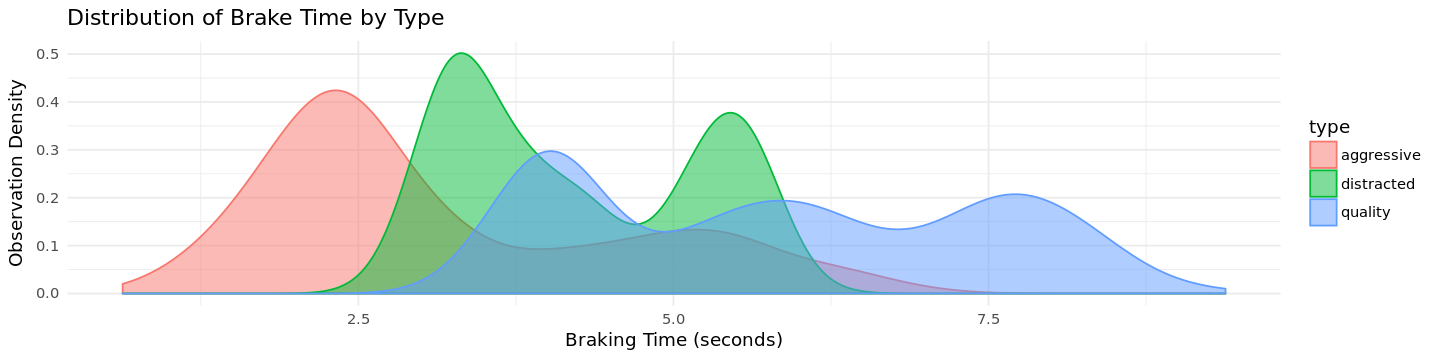

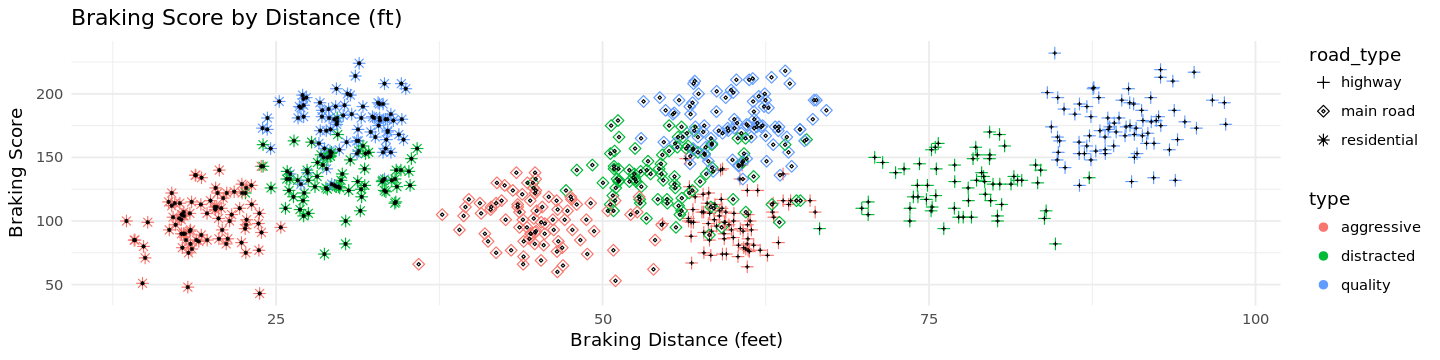

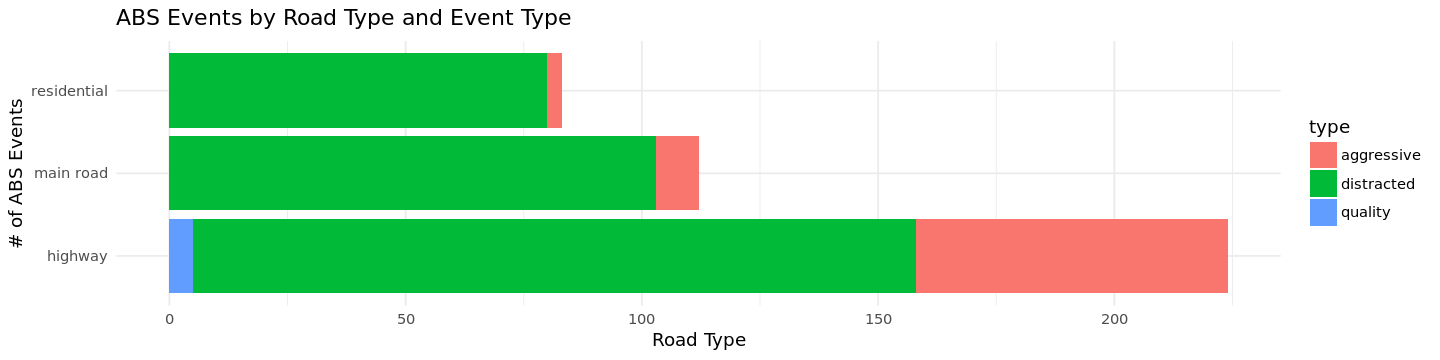

In [36]:
options(repr.plot.width = 12, repr.plot.height = 3)

ggplot(brakeEventDF, aes(x = brake_time_sec, color = type, fill = type)) + 
    geom_density(alpha = 0.5) +
    labs(x = "Braking Time (seconds)", y = "Observation Density", title = "Distribution of Brake Time by Type") +
    theme_minimal()

ggplot(sample_frac(brakeEventDF, .33), aes(x = brake_distance_ft, y = braking_score)) + 
    geom_point(aes(shape = road_type, color = type), size = 2) +
    scale_shape_manual(values=c(3, 5, 8)) +
    geom_point(color = 'black', size = 0.35, aes(shape = road_type)) +
    labs(x = "Braking Distance (feet)", y = "Braking Score", title = "Braking Score by Distance (ft)") +
    theme_minimal()

ggplot(aggDF, aes(x = road_type, y = abs_events)) + 
    geom_bar(aes(fill = type), stat = 'identity') + 
    coord_flip() +
    labs(x = "# of ABS Events", y = "Road Type", title = "ABS Events by Road Type and Event Type") +
    theme_minimal()

After visually inspecting the data, we see some clear grouping along the lines of event type, road type, and number of ABS events.  There is also an obvious linear relationship between brake score and brake time.  This historical data is clean enough to build a model from.

__________

<a id='ml'></a>


### Modeling

We can train a decision tree model on the historical brake event data.  It will learn the relationship between the various quantitative variables and the type of brake event, allowing us to classify new records as they come in.  In this case, we will be checking the behavior of drivers making warranty claims.

In [37]:
library(caTools)
library(randomForest)
library(caret)

#### Split data into train and test sets

In [38]:
## set the seed to make your partition reproductible
set.seed(22)

## Get row names for random sample of 70% of data
trainingRows <- row.names(brakeEventDF) %in% row.names(sample_frac(brakeEventDF, 0.7)) 

## Convert character columns to factor
brakeEventDF$type <- as.factor(brakeEventDF$type)
brakeEventDF$road_type <- as.factor(brakeEventDF$road_type
                                   )
## Split into train/test dataframes
trainingDF <- brakeEventDF[trainingRows, ]
testingDF <- brakeEventDF[!trainingRows, ]

## Check dimensions, should add up to 2100
paste("Rows in training set: ", dim(trainingDF)[1])
paste("Rows in test set: ", dim(testingDF)[1])

[1] "Rows in training set:  1470"

[1] "Rows in test set:  630"

#### Select features, train model, evaluate accuracy

In [41]:
## Preserve VINs to add on after modeling
vins <- trainingDF$VIN

## Select columns for modeling
trainingDF <- select(trainingDF, type, brake_time_sec, brake_distance_ft, road_type, braking_score, 
                 brake_pressure20pct, brake_pressure40pct, brake_pressure60pct,
                 brake_pressure80pct, brake_pressure100pct, abs_event, travel_speed)

## Using `caret` package
brakeEventModel <- train(type ~ .,
                         data = trainingDF,
                         method = "rf",
                         ntree = 500,
                         proximity = TRUE)

testingDF <- select(testingDF, -VIN)

print("Confusion Matrix for Testing Data:")
table(predict(brakeEventModel, select(testingDF, -type)), testingDF$type)

[1] "Confusion Matrix for Testing Data:"


            
             aggressive distracted quality
  aggressive        268          0       0
  distracted          0        277       2
  quality             0          5     248

In [42]:
### Save Model in the DSX Repository

In [43]:
library(modelAccess)
library(jsonlite)

saveModel(model = brakeEventModel, name = "BrakeEventClassifierCaret")

ERROR: Error in library(modelAccess): there is no package called ‘modelAccess’


The accuracy on this model is strong enough to give us some confidence in using it on new data.  

_________

<a id='export'></a>

### Model Export

Save model in the **DSX Local RStudio directory** for use in our Shiny app. When we save to the file system, we will not be able to take advantage of the built-in model deployment capabilties. However, we use this option  just for demo purposes because we can quickly integrate it with the Shiny application. To integrate with the model that has been saved in a DSX repository, we will need to deploy it for online scoring in **Deployment Manager** and invoke it from Shiny via RES

In [45]:
saveRDS(object = brakeEventModel, file = "brakeEventModel.rds")

Verify that the model has been saved. 

In [47]:
print(system("pwd", intern = TRUE))
print(system("ls -l", intern = TRUE))

[1] "/home/dsxuser/work"
[1] "total 4244"                                                           
[2] "-rw-r----- 1 dsxuser dsxuser 4344775 Apr 24 22:26 brakeEventModel.rds"


The model has successfully been saved to File System. 

Now save the model to the **ML Repository** so that it shows up in your project assets.

________

### Conclusion

In this notebook we have quickly explored and visualized brake event data using R.  We've also built, tested, and exported a decision tree model that can be embedded in applications or used to create reports.  To see the Shiny app where this model is used on customers coming into the service bay, click on 'Tools --> RStudio' in the menu bar above.

_______


<div><br><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/IBM_logo.svg/640px-IBM_logo.svg.png" width = 200 height = 200>
</div><br>